# Point Transformer
https://github.com/qq456cvb/Point-Transformers

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [2]:
import torch
!pip install open3d 1>/dev/null

In [3]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

KeyboardInterrupt: 

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

In [ ]:
!git pull

In [ ]:
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load dataset

In [ ]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [ ]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
dataset = ShapeNet15kPointClouds(root_dir=shapenet_location, tr_sample_size=1024, te_sample_size=1024)

## Load model

In [ ]:
%cd /content/gdrive/MyDrive/Developer
# !git clone https://github.com/qq456cvb/Point-Transformers
%cd Point-Transformers

In [ ]:
!pip install -r requirements.txt

### Linear Model
(debug only)

In [ ]:
from torch.nn import Linear

training_losses = []
val_losses = []

model = Linear(1024*3, 1024*3)

linearize_input = True

def linearize_batch(batch):
  return batch.reshape(batch.shape[0], batch.shape[1] * batch.shape[2])


def unlinearize_batch(batch):
  return batch.reshape(batch.shape[0], batch.shape[1] //3, 3)

### Point Transformer Model

In [116]:
from models.Hengshuang.model import PointTransformerSeg

class DotDict:
  pass

cfg = DotDict()
cfg.num_point = 1024
cfg.model = DotDict()
cfg.model.nneighbor=128
cfg.model.nblocks=4
cfg.model.transformer_dim=512
cfg.num_class=3
cfg.input_dim = 3

model = PointTransformerSeg(cfg)

# Losses
training_losses = []
val_losses = []
linearize_input = False

In [30]:
# Debug
import torch

def own_chamfer_distance(point_cloud1, point_cloud2):
    """
    Compute the Chamfer Distance between two point clouds.

    Parameters:
    - point_cloud1: A tensor of shape (N, 1024, 3)
    - point_cloud2: A tensor of shape (N, 1024, 3)

    Returns:
    - A tensor containing the Chamfer Distance for each pair of point clouds.
    """
    N, P, _ = point_cloud1.shape  # Assume point_cloud1 and point_cloud2 have the same shape

    # Expand dims to (N, P, 1, 3) for broadcasting
    point_cloud1_expanded = point_cloud1.unsqueeze(2)
    point_cloud2_expanded = point_cloud2.unsqueeze(1)

    # Compute squared distances (N, P, P)
    dists = torch.sum((point_cloud1_expanded - point_cloud2_expanded) ** 2, dim=-1)

    # Minimum along one axis (N, P)
    min_dists1 = torch.min(dists, dim=2)[0]  # (N, P)
    min_dists2 = torch.min(dists, dim=1)[0]  # (N, P)

    # Average minimum distance
    chamfer_dist = torch.mean(min_dists1, dim=1) + torch.mean(min_dists2, dim=1)

    return chamfer_dist

# Example usage
pc1 = torch.rand(10, 1024, 3)  # Random point cloud 1
pc2 = torch.rand(10, 1024, 3)  # Random point cloud 2

cd = chamfer_distance(pc1, pc2)
print(cd)


(tensor(0.0074), None)


In [31]:
def residuals_chamfer_distance(input, output):
  return own_chamfer_distance(input, input + output)

In [105]:
example_input = dataset[0]["train_points"]
example_batch = example_input.unsqueeze(0)
example_zeros = torch.zeros(example_batch.shape)
print((example_input + example_zeros).shape)
print(own_chamfer_distance(example_batch, example_zeros))
print(residuals_chamfer_distance(example_batch, example_zeros))

torch.Size([1, 1024, 3])
tensor([5.7275])
tensor([0.])


## Overfit model as an autoencoder on single point cloud



In [37]:
# loss, _ = chamfer_distance(input, output)
# print(loss)
example_batch.reshape(example_batch.shape[0], example_batch.shape[1] * example_batch.shape[2]).shape

torch.Size([1, 3072])

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
for param in model.parameters():
  param.to(device)

cpu


In [117]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
# TensorBoard Logging with model's name and current date

for epoch in range(100):
    # Train
    model.train()

    # Overfit on single pointcloud
    input = torch.unsqueeze(dataset[0]['train_points'], dim=0)
    # input.to(device)

    optimizer.zero_grad()
    print(input.shape)
    output = model(linearize_batch(input) if linearize_input else input)

    # Linear model
    # output = model(input.reshape(1, 1024*3))
    # output = output.reshape(1, 1024, 3)

    # loss, _ = chamfer_distance(output, input)
    if linearize_input:
      output = unlinearize_batch(output)
    loss = residuals_chamfer_distance(input, output)

    loss.backward()
    optimizer.step()

    epoch_train_loss = loss.item()
    training_losses.append(epoch_train_loss)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}")
    # visualize_pointcloud_eval(input.squeeze(), output.detach().squeeze()).show()

# Save the model
# model_save_path = f"output-models/pvcnn-refinement/PVCNN-Baseline-Refinement-e{epoch+1}.pth"
# torch.save(model.state_dict(), model_save_path)

torch.Size([1, 1024, 3])
Epoch 1,  Training Loss: 0.0281
torch.Size([1, 1024, 3])
Epoch 2,  Training Loss: 0.0181
torch.Size([1, 1024, 3])
Epoch 3,  Training Loss: 0.0126
torch.Size([1, 1024, 3])
Epoch 4,  Training Loss: 0.0093
torch.Size([1, 1024, 3])
Epoch 5,  Training Loss: 0.0083
torch.Size([1, 1024, 3])
Epoch 6,  Training Loss: 0.0072
torch.Size([1, 1024, 3])
Epoch 7,  Training Loss: 0.0052
torch.Size([1, 1024, 3])
Epoch 8,  Training Loss: 0.0048
torch.Size([1, 1024, 3])
Epoch 9,  Training Loss: 0.0044
torch.Size([1, 1024, 3])
Epoch 10,  Training Loss: 0.0043
torch.Size([1, 1024, 3])
Epoch 11,  Training Loss: 0.0037
torch.Size([1, 1024, 3])
Epoch 12,  Training Loss: 0.0031
torch.Size([1, 1024, 3])
Epoch 13,  Training Loss: 0.0026
torch.Size([1, 1024, 3])
Epoch 14,  Training Loss: 0.0024
torch.Size([1, 1024, 3])
Epoch 15,  Training Loss: 0.0019
torch.Size([1, 1024, 3])
Epoch 16,  Training Loss: 0.0018
torch.Size([1, 1024, 3])
Epoch 17,  Training Loss: 0.0018
torch.Size([1, 1024, 3]

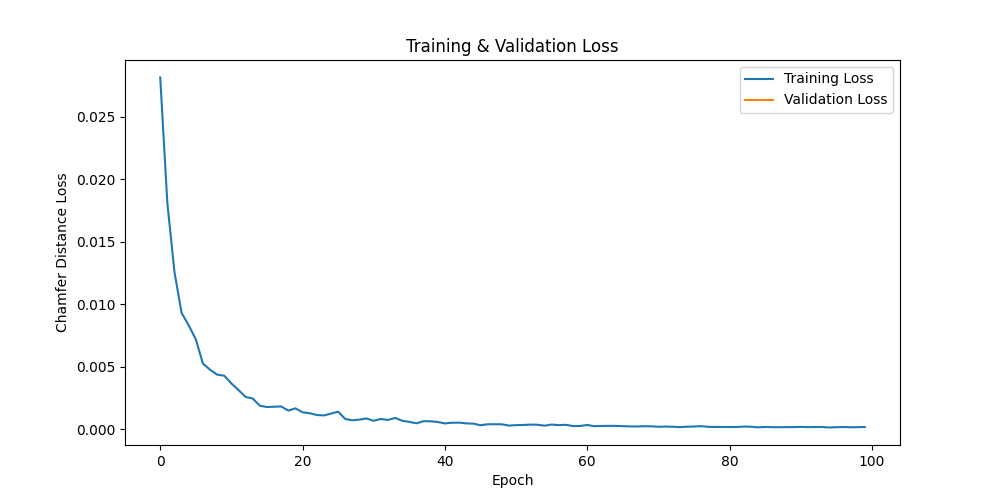

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

## Visualize example

In [124]:
model.eval()
# input = torch.unsqueeze(dataset[0]['train_points'], dim=0)
with torch.no_grad():
  output = model(linearize_batch(input) if linearize_input else input)
  if linearize_input:
    output = unlinearize_batch(output)
# output = output.reshape(1, 1024, 3)
output.shape

torch.Size([1, 1024, 3])

In [125]:
print(input.shape, output.shape, (input + output).shape)
print(input+output)
print(chamfer_distance(input, output)[0], own_chamfer_distance(input, output), residuals_chamfer_distance(input, output))

torch.Size([1, 1024, 3]) torch.Size([1, 1024, 3]) torch.Size([1, 1024, 3])
tensor([[[ 0.0931, -0.4251,  3.0434],
         [-0.3180, -0.3565,  0.5893],
         [-0.2720, -0.0905,  1.0372],
         ...,
         [ 0.5150, -0.1246,  2.4684],
         [ 0.8255,  1.1457,  4.1577],
         [ 0.4980, -0.0986,  2.3273]]])
tensor(5.6175) tensor([5.6175]) tensor([0.0004])


In [126]:
print(output.mean(), output.std(), output.min(), output.max())

tensor(-0.0020) tensor(0.0081) tensor(-0.0271) tensor(0.0291)


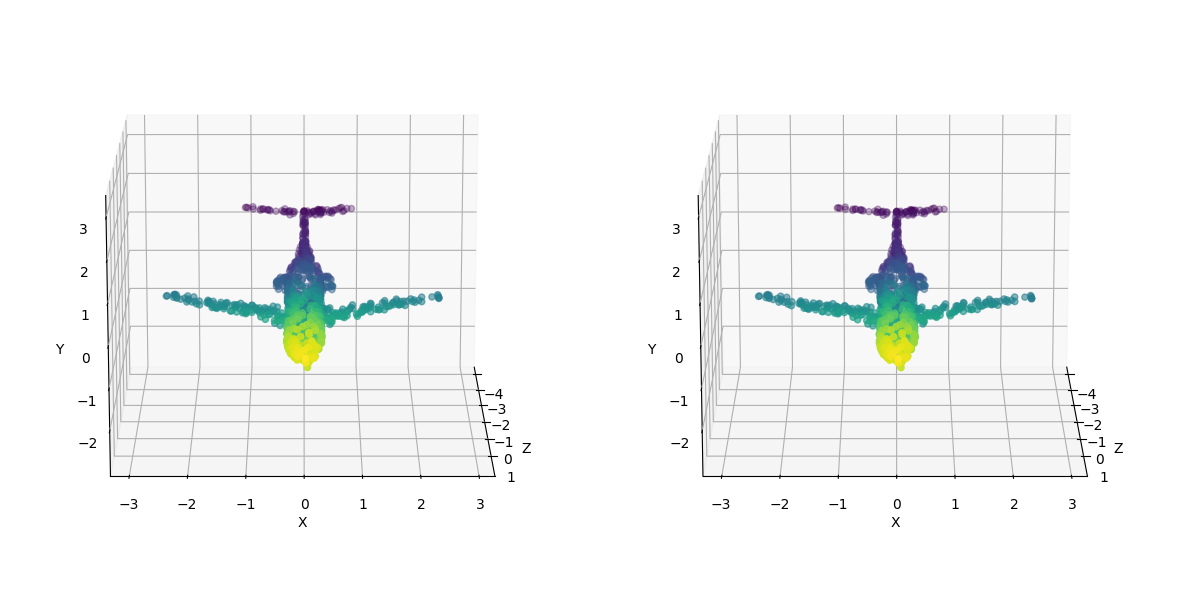

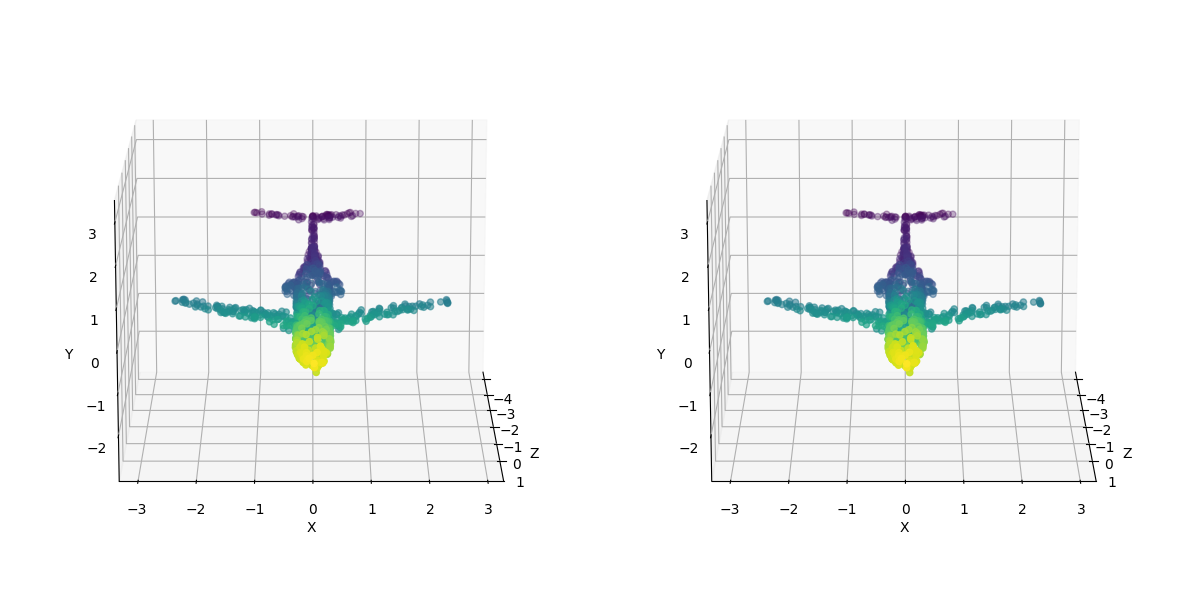

In [127]:
visualize_pointcloud_eval(input.squeeze(), (input + output).squeeze())